You're absolutely on the right track with BioPython! It's the go-to library for interacting with biological databases like NCBI programmatically in Python. Specifically, you'll be using the Bio.Entrez module.


Here's a breakdown of how to download a gene sequence from NCBI using BioPython, along with explanations and best practices:

Key BioPython Bio.Entrez Functions
- Entrez.email: Crucial! You must set your email address before making any requests to NCBI. This helps NCBI understand who is using their E-utilities and allows them to contact you if there are issues. Without it, your requests might be blocked.

- Entrez.api_key (Optional but Recommended): You can obtain an API key from your NCBI account. This allows you to make more requests per second (10 requests/second with a key vs. 3 requests/second without). For serious or frequent programmatic access, an API key is highly recommended to avoid hitting rate limits.
- Entrez.esearch(): This function performs a search on an NCBI database (e.g., "nucleotide," "gene," "protein," "pubmed") and returns a list of matching IDs.
Entrez.efetch(): Once you have the IDs, this function retrieves the full record(s) from the specified database in a desired format (e.g., FASTA, GenBank).
- Entrez.read(): This function parses the XML output returned by esearch or efetch (when retmode="xml") into Python dictionaries and lists.
- SeqIO.read() / SeqIO.parse(): From Bio.SeqIO, these functions are used to parse sequence files (or "handles" from efetch) into SeqRecord objects, which are very convenient for working with sequence data.

## Step-by-Step Example: Downloading a Gene
Let's say you want to download the sequence for the E. coli lacZ gene.

In [5]:
from Bio import Entrez
from Bio import SeqIO
import time # To respect NCBI's rate limits

# --- 1. Set your email and API key (if you have one) ---
# IMPORTANT: Replace with your actual email address
Entrez.email = "wjxa20152015@gmail.com"
# Optional: If you have an NCBI API key, uncomment and replace
# Entrez.api_key = "YOUR_NCBI_API_KEY"

# --- 2. Define your search query ---
# We'll search the 'gene' database first to get the gene ID,
# then use that to search the 'nucleotide' database for the sequence.
organism = "Escherichia coli"
gene_name = "lacZ"
search_term = f"{organism}[Organism] AND {gene_name}[Gene]"

print(f"Searching for gene: {search_term}")

# --- 3. Search for the gene ID in the 'gene' database ---
try:
    handle = Entrez.esearch(db="gene", term=search_term, retmax="1") # retmax=1 to get the most relevant one
    record = Entrez.read(handle)
    handle.close()

    gene_ids = record["IdList"]

    if not gene_ids:
        print(f"No gene ID found for '{search_term}'. Please check your search term.")
    else:
        ncbi_gene_id = gene_ids[0]
        print(f"Found NCBI Gene ID: {ncbi_gene_id}")

        # --- 4. Fetch the nucleotide sequence using the gene ID ---
        # We need to specify the 'nucleotide' database for sequence data.
        # rettype='fasta' for FASTA format, 'gb' for GenBank format.
        # retmode='text' for plain text output.
        print(f"Fetching nucleotide sequence for Gene ID: {ncbi_gene_id}")
        # Pause to respect NCBI's rate limits (especially if not using API key)
        time.sleep(0.5)

        # For gene records, fetching the nucleotide sequence often involves searching
        # the nucleotide database with the gene's locus tag or gene name in that context.
        # A more robust way is to use the gene ID to find associated nucleotide records.
        # Let's search the nucleotide database for the gene ID directly, or its accession.
        # For simplicity, we'll try searching by gene name and organism again in 'nucleotide'
        # or use the gene ID to link to a nucleotide entry if possible.
        # Often, gene entries link to specific RefSeq accessions.

        # A common approach: Use the Gene ID to find associated nucleotide records
        # This can be tricky because a gene entry might link to a whole genome, not just the gene sequence.
        # Let's try searching for the gene name and organism directly in the nucleotide database.
        # This is often more straightforward for getting the actual gene sequence.
        nucleotide_search_term = f"{organism}[Organism] AND {gene_name}[Gene] AND refseq[Filter]"

        handle_nuc = Entrez.esearch(db="nucleotide", term=nucleotide_search_term, retmax="5")
        nuc_record = Entrez.read(handle_nuc)
        handle_nuc.close()

        nucleotide_ids = nuc_record["IdList"]

        if not nucleotide_ids:
            print(f"No nucleotide sequence found for '{nucleotide_search_term}'. Trying broader search.")
            # Fallback: if RefSeq filter didn't work, try without it
            handle_nuc_broad = Entrez.esearch(db="nucleotide", term=f"{organism}[Organism] AND {gene_name}[Gene]", retmax="5")
            nuc_record_broad = Entrez.read(handle_nuc_broad)
            handle_nuc_broad.close()
            nucleotide_ids = nuc_record_broad["IdList"]


        if nucleotide_ids:
            # Let's just take the first result for demonstration
            target_nucleotide_id = nucleotide_ids[0]
            print(f"Found Nucleotide ID: {target_nucleotide_id}")

            # Fetch the sequence in FASTA format
            time.sleep(0.5) # Respect rate limits
            handle_fetch = Entrez.efetch(db="nucleotide", id=target_nucleotide_id, rettype="fasta", retmode="text")
            fasta_sequence = handle_fetch.read()
            handle_fetch.close()

            print("\n--- FASTA Sequence ---")
            print(fasta_sequence[:100] + '...')

            # Optionally, parse it with SeqIO to get a SeqRecord object
            from io import StringIO
            seq_record = SeqIO.read(StringIO(fasta_sequence), "fasta")
            print("\nSequence ID:", seq_record.id)
            print("Sequence Length:", len(seq_record.seq))
            print("First 50 bases:", seq_record.seq[:50])

            # You can also save it to a file
            output_filename = f"{seq_record.id}_{gene_name}.fasta"
            with open(output_filename, "w") as out_handle:
                out_handle.write(fasta_sequence)
            print(f"\nSequence saved to {output_filename}")

            # If you want GenBank format:
            time.sleep(0.5) # Respect rate limits
            handle_fetch_gb = Entrez.efetch(db="nucleotide", id=target_nucleotide_id, rettype="gb", retmode="text")
            genbank_record = handle_fetch_gb.read()
            handle_fetch_gb.close()

            print("\n--- GenBank Record (first 500 chars) ---")
            print(genbank_record[:500]) # Print first 500 characters
            # You can parse the GenBank record with SeqIO as well:
            # gb_seq_record = SeqIO.read(StringIO(genbank_record), "genbank")
            # print("GenBank features:", gb_seq_record.features)

            output_genbank_filename = f"{seq_record.id}_{gene_name}.gb"
            with open(output_genbank_filename, "w") as out_handle_gb:
                out_handle_gb.write(genbank_record)
            print(f"GenBank record saved to {output_genbank_filename}")

        else:
            print("Could not find any nucleotide sequences for the specified gene.")

except Exception as e:
    print(f"An error occurred: {e}")

Searching for gene: Escherichia coli[Organism] AND lacZ[Gene]
Found NCBI Gene ID: 945006
Fetching nucleotide sequence for Gene ID: 945006
Found Nucleotide ID: 2195797308

--- FASTA Sequence ---
>NZ_CAKNDS010000021.1 Escherichia coli strain cpe078, whole genome shotgun sequence
TGGCGGCTAATGGCAA...

Sequence ID: NZ_CAKNDS010000021.1
Sequence Length: 20027
First 50 bases: TGGCGGCTAATGGCAAGAAAGGAAAGGTGATTCTCGGCGCGATGATGCGC

Sequence saved to NZ_CAKNDS010000021.1_lacZ.fasta

--- GenBank Record (first 500 chars) ---
LOCUS       NZ_CAKNDS010000021     20027 bp    DNA     linear   CON 21-MAY-2025
DEFINITION  Escherichia coli strain cpe078, whole genome shotgun sequence.
ACCESSION   NZ_CAKNDS010000021 NZ_CAKNDS010000000
VERSION     NZ_CAKNDS010000021.1
DBLINK      BioProject: PRJNA224116
            BioSample: SAMEA6451093
            Assembly: GCF_929618365.1
KEYWORDS    WGS; RefSeq.
SOURCE      Escherichia coli
  ORGANISM  Escherichia coli
            Bacteria; Pseudomonadati; Pseudomonadota;

In [6]:
from pathlib import Path

file = list(Path('.').glob("*.fasta"))[0]
content = file.read_text(encoding='utf8')
print(content[:100] + '...')

>NZ_CAKNDS010000021.1 Escherichia coli strain cpe078, whole genome shotgun sequence
TGGCGGCTAATGGCAA...


In [4]:
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
from Bio import SeqIO
from io import StringIO
import time

# --- 1. Get your query sequence ---
# For demonstration, let's assume you have a FASTA string of your downloaded gene.
# In a real scenario, you would have loaded this from your downloaded .fasta file.
# Let's use the lacZ gene from the previous example for consistency.
# Replace this with your actual gene sequence (e.g., from reading the downloaded .fasta file)
lacZ_fasta_string = content
# For a real file:
# with open("your_gene.fasta", "r") as f:
#     query_sequence_fasta = f.read()

# --- 2. Perform the BLAST search ---
print("Performing BLAST search... This may take a moment.")
# Example for nucleotide sequence (blastn)
# For protein sequences, you'd use 'blastp' or 'blastx' (nucleotide to protein)
# db: The database to search against (e.g., 'nr' for non-redundant, 'nt' for nucleotide, 'refseq_rna', 'refseq_genomic')
# You can find available databases on the NCBI BLAST website.
# Use a common database like 'nr' (nucleotide non-redundant) or 'nt' (nucleotide) for general searches.
# filter: 'L' for low complexity filter (recommended for most searches to avoid spurious hits)

try:
    result_handle = NCBIWWW.qblast(
        program="blastn",  # or 'blastp', 'blastx', 'tblastn', 'tblastx'
        database="nr",     # or 'nt', 'refseq_rna', 'refseq_genomic', etc.
        sequence=lacZ_fasta_string,
        # Set a few more parameters if needed
        # gapopen=11,
        # gapextend=1,
        # expect=10.0, # Expectation value (E-value) cutoff
        # hitlist_size=10, # Number of descriptions and alignments to show
        # format_type="XML" # The default format for NCBIXML parsing
    )
    # Pause to respect NCBI's rate limits (especially after a long query)
    time.sleep(5) # A longer pause is often good after submitting a query

except Exception as e:
    print(f"An error occurred during BLAST query: {e}")
    print("Consider adding Entrez.email and Entrez.api_key if you haven't already.")
    exit()

# --- 3. Parse the BLAST results ---
# The results are returned in XML format, which BioPython's NCBIXML can parse.
print("Parsing BLAST results...")
blast_records = NCBIXML.parse(result_handle) # parse() for multiple query sequences
# For a single query, you can use read():
# blast_record = NCBIXML.read(result_handle)

# Iterate through the results (there might be multiple records if you queried multiple sequences)
n = 0
for blast_record in blast_records:
    print(f"\nQuery: {blast_record.query}")
    print(f"Database: {blast_record.database}")
    print(f"Number of hits found: {len(blast_record.alignments)}")

    if not blast_record.alignments:
        print("No significant alignments found.")
        continue

    # Iterate through the alignments (hits)
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps: # HSP = High-scoring Segment Pair
            if hsp.expect < 1e-10: # Filter by E-value (lower is better, closer to 0)
                n +=1
                if n >= 10: # first 10 results
                  break
                print(f"\n  Alignment: {alignment.title}")
                print(f"  Length: {alignment.length}")
                print(f"  E-value: {hsp.expect}")
                print(f"  Score: {hsp.score}")
                print(f"  Identities: {hsp.identities}/{hsp.align_length} ({hsp.positives} positives)")
                print(f"  Query start: {hsp.query_start}, end: {hsp.query_end}")
                print(f"  Subject start: {hsp.sbjct_start}, end: {hsp.sbjct_end}")
                # You can print the actual alignment if needed
                # print(f"  Query: {hsp.query[0:75]}...")
                # print(f"  Match: {hsp.match[0:75]}...")
                # print(f"  Sbjct: {hsp.sbjct[0:75]}...")
    break # Only process the first query for this example

result_handle.close()
print("\nBLAST search complete.")

Performing BLAST search... This may take a moment.
Parsing BLAST results...

Query: NZ_CAKNDS010000021.1 Escherichia coli strain cpe078, whole genome shotgun sequence
Database: core_nt
Number of hits found: 50

  Alignment: gi|1915194479|dbj|AP022409.1| Escherichia coli STW0522-31 DNA, complete genome
  Length: 4783805
  E-value: 0.0
  Score: 40054.0
  Identities: 20027/20027 (20027 positives)
  Query start: 1, end: 20027
  Subject start: 3547756, end: 3567782

  Alignment: gi|1915194479|dbj|AP022409.1| Escherichia coli STW0522-31 DNA, complete genome
  Length: 4783805
  E-value: 1.66533e-119
  Score: 497.0
  Identities: 280/298 (280 positives)
  Query start: 1, end: 292
  Subject start: 1600979, end: 1600682

  Alignment: gi|1915194479|dbj|AP022409.1| Escherichia coli STW0522-31 DNA, complete genome
  Length: 4783805
  E-value: 7.08116e-118
  Score: 490.0
  Identities: 274/292 (274 positives)
  Query start: 1, end: 292
  Subject start: 3567840, end: 3567555

  Alignment: gi|1915194479

Successfully loaded GenBank file: NZ_CAKNDS010000021.1 (20027 bp)


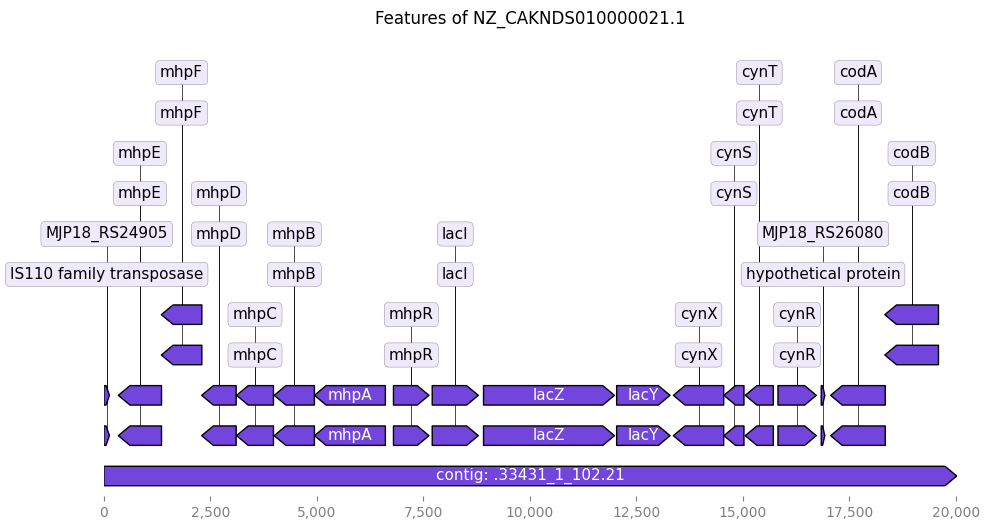

In [7]:
from Bio import SeqIO
from dna_features_viewer import BiopythonTranslator
import matplotlib.pyplot as plt

# --- 1. Load the GenBank file into a Biopython SeqRecord object ---
# Replace 'your_gene.gb' with the actual path to your downloaded GenBank file
try:
    record = SeqIO.read("NZ_CAKNDS010000021.1_lacZ.gb", "genbank")
    print(f"Successfully loaded GenBank file: {record.id} ({len(record.seq)} bp)")
except FileNotFoundError:
    print("Error: 'NZ_CAKNDS010000021.1_lacZ.gb' not found. Please make sure the file exists.")
    # You might want to add code here to re-download the file if it's missing.
    exit()
except Exception as e:
    print(f"Error loading GenBank file: {e}")
    exit()

# --- 2. Translate the Biopython record into a DNA Features Viewer GraphicRecord ---
# BiopythonTranslator automatically converts GenBank features into GraphicFeature objects.
graphic_record = BiopythonTranslator().translate_record(record)

# --- 3. Plot the graphic record ---
# This will generate a linear plot of your sequence with its features.
# 'figure_width' controls the width of the plot in inches.
ax, _ = graphic_record.plot(figure_width=10)

# --- 4. Add a title to your plot (optional) ---
ax.set_title(f"Features of {record.id}")

# --- 5. Display or save the plot ---
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show() # Displays the plot

# To save the plot to a file instead of displaying:
# plt.savefig("gene_features_linear.png", dpi=300)
# plt.close() # Close the figure to free up memory